In [1]:
import numpy as np
import matplotlib.pyplot as plt
from waveforms import cos,sin,gaussian, cosPulse,zero, square
from scipy.signal import savgol_filter,correlate
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import integrate

from pathlib import Path
import os
import time as TM
from quantum_driver.NS_MCI import Driver

180000


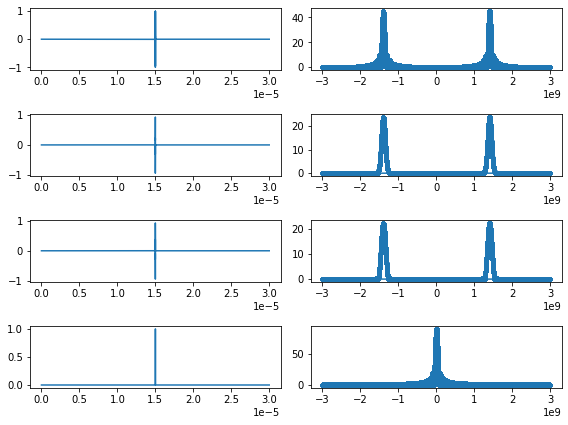

In [2]:
samplerate = 6e9

time_len = 30e-6
width = 15e-9
freq = 1400e6
time = np.linspace(0,time_len,int(time_len*samplerate))

wav1 = (cos(2*np.pi*freq))*(square(width,edge=2e-9)>>time_len/2)
wav2 = (cos(2*np.pi*freq))*(gaussian(width)>>time_len/2)
#t3,wav3 = Pulse_wav(envelope= 'cosPulse', width = width, freq=freq, time_len= time_len)
wav3 = (cos(2*np.pi*freq))*(cosPulse(width)>>time_len/2)
# t3,wav3 = Pulse_wav(waveform = 'cos',samplerate = samplerate,freq = freq,time_len = time_len ,width = width,repeat = 1)

wav4 = (square(width)>>time_len/2)


print(len(wav1(time)))
fig,axs = plt.subplots(4,2,figsize=(8, 6))
# axs = axs.flatten()
for i in range(4):
    axs[i][0].plot(time,eval(f'wav{i+1}(time)'))
    fft_freq = np.fft.fftfreq(int(time_len*samplerate),1/samplerate)
    axs[i][1].plot(fft_freq,np.abs(np.fft.fft(np.hamming(int(time_len*samplerate))*(eval(f'wav{i+1}(time)')))),'.-')
fig.tight_layout()

In [6]:
driver = Driver('192.168.1.194')
driver.open(system_parameter = {'RefClock': 'in'})

指令初始化执行成功
指令DAC配置执行成功
指令ADC配置执行成功


In [7]:
driver.set('PointNumber', 1+5j, 1)

远程函数报错: 
<class 'NS_MCI.config.RPCMethodExecuteError'>:Traceback with variables (most recent call last):
  File "/home/digilab/RFSdemo/NS_MCI/config.py", line 116, in wrap
    return func(*args, **kwargs)
      args = (<__main__.RFSKitRPCServer object at 0x7f60ae0fa0>, 'PointNumber', ['complex', 1.0, 5.0], 1)
      kwargs = {}
      e = TypeError("int() argument must be a string, a bytes-like object or a real number, not 'complex'")
      func = <function RFSKitRPCServer.rpc_set at 0x7f60ae52d0>
  File "/home/digilab/RFSdemo/rpcserver.py", line 169, in rpc_set
    self.rfs_kit.set_param_value(param_name, value)
      self = <__main__.RFSKitRPCServer object at 0x7f60ae0fa0>
      name = 'PointNumber'
      value = (1+5j)
      channel = 0
      execute = True
      param_name = 'ADC0门宽'
  File "/home/digilab/RFSdemo/NS_MCI/basekit.py", line 184, in set_param_value
    return self.icd_param.set_param(param_name, value, fmt_type)
      self = <NS_MCI.basekit.RFSKit object at 0x7f60ae10f0>

In [3]:
from xmlrpc.server import SimpleXMLRPCServer
import numpy as np
from typing import List, Tuple
import waveforms

from NS_MCI.tools.printLog import *
from NS_MCI.config import solve_exception
from NS_MCI.interface import DataNoneInterface, CommandTCPInterface
from NS_MCI import RFSKit
from NS_MCI.tools.data_unpacking import UnPackage
from NS_MCI.xdma import LightDMAMixin
from NS_MCI.config import param_cmd_map
from svqbit import SolveQubit
from quantum_driver.NS_MCI import RPCValueParser

CommandTCPInterface._timeout = 10
CommandTCPInterface._target_id = '192.168.1.175'
rfs_kit = RFSKit(auto_load_icd=True,
                              auto_write_file=False,
                              cmd_interface=CommandTCPInterface,
                              data_interface=DataNoneInterface)
rfs_kit.start_command()
rfs_kit.set_param_value('DAC通道选择', 1)
value = wav3(time).tobytes()

Info: 参数载入成功


In [4]:
start = TM.time()
for i in range(10):
    rfs_kit.execute_command('DAC数据更新', True, value)
print(TM.time()-start)

3.5637688636779785


In [6]:
%timeit rfs_kit.execute_command('DAC数据更新', True, value)

356 ms ± 92.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
driver = Driver('192.168.1.194')
driver.open(system_parameter = {'RefClock': 'in'})

指令初始化执行成功
指令DAC配置执行成功
指令ADC配置执行成功


In [5]:
%timeit driver.set('Waveform', wav3(time), 1)

Waveform 配置成功
Waveform 配置成功
Waveform 配置成功
Waveform 配置成功
Waveform 配置成功
Waveform 配置成功
Waveform 配置成功
Waveform 配置成功
181 ms ± 5.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
